In [1]:
%cd "/Users/fan/OneDrive - University of Southampton/My-Projects/Edge-Cloud-Resource-Allocation/marl-edge-cloud/src/"
from common.generate_simulation_data import generate_synthetic_data_edge_cloud
import pandas as pd
import numpy as np
import yaml
import copy
from pprint import pprint
from IPython.core.interactiveshell import InteractiveShell
from matplotlib import pyplot as plt

InteractiveShell.ast_node_interactivity = "all"
# https://ipython.readthedocs.io/en/stable/config/options/terminal.html
pd.set_option("display.max_rows", None, "display.max_columns", None)


/Users/fan/OneDrive - University of Southampton/My-Projects/Edge-Cloud-Resource-Allocation/marl-edge-cloud/src


In [2]:
with open("/Users/fan/OneDrive - University of Southampton/My-Projects/Edge-Cloud-Resource-Allocation/marl-edge-cloud/configs/local_5-actions_first-price_no-history_revenue.yaml", 'r') as stream:
    try:
        parsed_yaml = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

config = parsed_yaml['env-config']
print(config)

{'n_nodes': 3, 'num_agents': 3, 'n_tasks_in_total': 42, 'n_tasks_to_allocate': 40, 'duration': 7, 'usage_time_ub': 3, 'seed': 124, 'random_seed': True, 'avg_resource_capacity': {0: [6, 6, 6], 1: [6, 6, 6], 2: [4, 4, 4]}, 'avg_unit_cost': {0: [2, 2, 2], 1: [2, 2, 2], 2: [5, 5, 5]}, 'verbose': False, 'record_history': False, 'history_len': 4, 'cooperative': False, 'n_actions': 5, 'auction_type': 'first-price'}


In [3]:
class EdgeCloudEnv():
    def __init__(self, config, seed=0, n_timesteps=10, n_tasks=50,
                 max_steps=11,
                 p_high_value_tasks=0.3, high_value_slackness=0,
                 low_value_slackness=0, resource_ratio=1, valuation_ratio=20,
                 resource_coefficient=0.2,
                 forgiveness_factor=30, 
                 allow_negative_reward=False,
                 alpha=1.0, lam=1e2, occup_len=4, history_len=3):
        """
        Initialization function for the environment.
        Args:

            seed: seed_value for generating simulation data
            duration The number of timestamps.
            allow_negative_reward: Flag for allowing negative rewards for the bad
            allocation of tasks.
            forgiveness_factor: Tolerance to sequential bad allocation of tasks.
            alpha: Percentage of the total rewards influenced by the prioritisation of
            high valuation tasks.
            lam: Speed of increase in the rewards generated from the prioritisation of
            high valuation tasks.
            not_verbose: A boolean as a flag to logging.debug information about the node
            allocation.
            record_history: whether to put others' action history to the observation of an agent
            occup_len: how many time steps of future occupancy is in observations
        """
        self.occup_len = config['usage_time_ub']
        self.current_task = None
        self.current_time_slot = None
        self.next_time_slot = None
        self.n_tasks_expensive = 0
        self.winner_id = None
        self.winner_usage_time = None
        self.winner_start_time = None
        self.winner_finish_time = None
        self.resource_capacity_dict = None
        self.future_occup = None
        self.current_task_value = None
        self.df_tasks_relative = None
        self.record_history = config['record_history']
        self.cooperative = config['cooperative']
        self.rewards = {}
        self.sw_increase = None
        self.obs = {}
        self.state = {}
        self.avg_resource_capacity = config["avg_resource_capacity"]
        self.avg_unit_cost = config["avg_unit_cost"]
        self.n_tasks_to_allocate = config[
                                       'n_tasks_to_allocate'] + 1  # the number of tasks to allocate (+1 so that the program can work)
        self.history_len = config['history_len']

        self.n_tasks_in_total = config[
            'n_tasks_in_total']  # the number of tasks for generating the simulation data
        self.duration = config['duration']  # the duration of the allocation
        resource_coefficient = (
                resource_coefficient * self.n_tasks_in_total / self.duration)
        self.seed_value = config['seed']
        self.n_nodes = config['n_nodes']
        self.n_actions = config['n_actions']
        self.p_high_value_tasks = p_high_value_tasks
        self.high_value_slackness = high_value_slackness
        self.low_value_slackness = low_value_slackness
        self.resource_ratio = resource_ratio
        self.valuation_ratio = valuation_ratio
        self.resource_coefficient = resource_coefficient
        self.usage_time_ub = config['usage_time_ub']
        self.auction_type = config['auction_type']
        self.verbose = config["verbose"]
        # record the allocation scheme (task_id: [node_id, start_time, end_time])
        self.allocation_scheme = pd.DataFrame(
            columns=['node_id', 'start_time', 'end_time'])

        (df_tasks, df_nodes, n_time, n_tasks,
         n_nodes) = self.data_for_next_episode()

        self.allocated_tasks = []  # [(task_info, action)]

        self.lam = lam
        self.alpha = alpha
        self.allow_negative_reward = allow_negative_reward
        self.n_resource_type = 3

        # initialise the ndarray of idle resources
        self.full_resource_capacities = np.empty(
            [self.n_nodes, self.n_resource_type, self.duration])

        for node in df_nodes.iterrows():
            self.full_resource_capacities[node[0]] = [
                [df_nodes.loc[node[0], 'CPU'] for _ in range(self.duration)],
                [df_nodes.loc[node[0], 'RAM'] for _ in range(self.duration)],
                [df_nodes.loc[node[0], 'storage'] for _ in range(self.duration)]]

        self.df_tasks = df_tasks
        self.df_nodes = df_nodes

        self.current_task_id = 0
        self.failed = 0

        self.forgiveness_factor = forgiveness_factor

        self.total_social_welfare = 0
        self.total_allocated_tasks_num = 0

        self.processed_tasks = 0
        self.action_history = []

        self.allocation_map = dict((node, []) for node in range(
            self.n_nodes))  # A dict with the shape {node: [(task, start_index,
        # stop_index),]}

        self.idle_resource_capacities = copy.deepcopy(
            self.full_resource_capacities)

        self._episode_ended = False
        # an upper bound of the social welfare
        self.total_possible_reward = sum(
            df_tasks.valuation_coefficient * df_tasks.usage_time)
       

    def data_for_next_episode(self):
        df_tasks, df_nodes, n_time, n_tasks, n_nodes = \
            generate_synthetic_data_edge_cloud(self.avg_resource_capacity,
                                               self.avg_unit_cost,
                                               n_tasks=self.n_tasks_in_total,
                                               n_time=self.duration,
                                               seed=self.seed_value, n_nodes=self.n_nodes,
                                               p_high_value_tasks=self.p_high_value_tasks,
                                               high_value_slackness_lower_limit=self.high_value_slackness,
                                               high_value_slackness_upper_limit=self.high_value_slackness,
                                               low_value_slackness_lower_limit=self.low_value_slackness,
                                               low_value_slackness_upper_limit=self.low_value_slackness,
                                               resource_demand_high=self.resource_ratio,
                                               vc_ratio=self.valuation_ratio,
                                               k_resource=self.resource_coefficient,
                                               usage_time_ub=self.usage_time_ub)
        return df_tasks, df_nodes, n_time, n_tasks, n_nodes

In [4]:
env_1 = EdgeCloudEnv(config)

In [27]:
print(randint(0,1e6))

691518


In [32]:
# get 10 means
from random import randint
from statistics import mean
mean_value_list = []

for _ in range(10):
    a = randint(0,1e6)
    episode_value_list = []
    for env_1.seed_value in range(a, a+100):
        df_tasks, df_nodes, n_time, n_tasks, n_nodes = env_1.data_for_next_episode()
        # create a column 'value'
        df_tasks['value'] = df_tasks['valuation_coefficient'] * df_tasks['usage_time']
        # get a sum of the 'value' column
        df_tasks.loc["Total", 'value'] = df_tasks.value.sum()
        # record this 'total value' of this episode
        episode_value_list.append(df_tasks.loc["Total", 'value'])
    mean_value_list.append(mean(episode_value_list))
mean_value_list

[60920.07618997407,
 60672.453250462175,
 61107.36785546711,
 60568.6706234759,
 60764.922135033776,
 60760.531381181354,
 60982.3712686029,
 60947.53176170486,
 61023.70508123331,
 60604.46492473129]

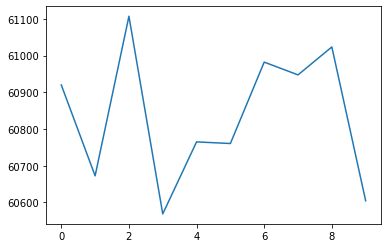

In [33]:
plt.plot(mean_value_list)
plt.show()

In [34]:
df_tasks.head(20)

,valuation_coefficient,arrive_time,start_time,deadline,usage_time,CPU,RAM,storage,value
0,99.873318,0.077837,1.0,3.0,3.0,2.767451,2.596997,2.701871,299.619954
1,90.697047,0.116768,1.0,3.0,3.0,2.835356,2.365677,2.645587,272.091142
2,90.065392,0.144029,1.0,3.0,3.0,2.796662,2.150788,2.668771,270.196175
3,1587.461456,0.216493,1.0,3.0,3.0,4.706979,4.093460,3.238289,4762.384367
4,1216.857570,0.255196,1.0,3.0,3.0,3.362761,3.683260,3.267887,3650.572711
5,99.982433,0.317913,1.0,3.0,3.0,2.834833,2.647236,2.053137,299.947300
6,1590.329106,0.335033,1.0,3.0,3.0,3.039515,4.216284,3.211411,4770.987319
7,66.420158,0.356653,1.0,3.0,3.0,2.211150,2.231114,2.983358,199.260475
8,1128.075723,0.380965,1.0,3.0,3.0,4.422584,3.329381,4.822757,3384.227169
9,67.209414,0.390323,1.0,3.0,3.0,2.372168,2.459204,2.227952,201.628243


In [7]:
df_tasks.loc["Total", 'value'] = df_tasks.value.sum()
df_tasks.tail()

,valuation_coefficient,arrive_time,start_time,deadline,usage_time,CPU,RAM,storage,value
38,82.028046,3.868119,4.0,6.0,3.0,2.100550,2.436171,2.737111,246.084138
39,91.405403,3.890737,4.0,6.0,3.0,2.389050,2.111874,2.550275,274.216208
40,89.600029,3.905098,4.0,6.0,3.0,2.998018,2.835875,2.529072,268.800087
41,70.652052,3.933603,4.0,6.0,3.0,2.062567,2.196024,2.453829,211.956156
Total,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51625.896156
